In [23]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from truvari.refine import make_region_report
import json

In [2]:
def mk_key(x):
    return f"{x['chrom']}:{x['start']}-{x['end']}"

In [24]:
trgt_data = pd.read_csv("../results/trgt_strawman/refine.regions.txt", sep='\t')
trgt_report = json.load(open("../results/trgt_strawman/refine.region_summary.json"))
trgt_data['key'] = trgt_data.apply(mk_key, axis=1)

hip_data = pd.read_csv("../results/hipstr_strawman/refine.regions.txt", sep='\t')
hip_report = json.load(open("../results/hipstr_strawman/refine.region_summary.json"))
hip_data['key'] = hip_data.apply(mk_key, axis=1)

gang_data = pd.read_csv("../results/gangstr_strawman/refine.regions.txt", sep='\t')
gang_report = json.load(open("../results/gangstr_strawman/refine.region_summary.json"))
gang_data['key'] = gang_data.apply(mk_key, axis=1)


bed_performance = pd.DataFrame([trgt_report, hip_report, gang_report])
bed_performance['program'] = ["TRGT", "HipSTR", "GangSTR"]
bed_performance

,TP,TN,FP,FN,condition P,condition N,test P,test N,PPV,TPR,TNR,NPV,ACC,BA,F1,UND,program
0,56825,97113,5264,2633,60870,100591,62804,98657,0.904799,0.933547,0.965424,0.984350,0.953407,0.949486,0.918948,2,TRGT
1,35459,74949,2176,11671,47552,76499,38079,85972,0.931196,0.745689,0.979738,0.871784,0.890021,0.862714,0.828181,0,HipSTR
2,22339,41227,2093,4934,27555,42085,25081,44559,0.890674,0.810706,0.979613,0.925223,0.912780,0.895159,0.848811,1,GangSTR


In [25]:
trgt_data.set_index(['key'], inplace=True)
a = set(trgt_data.index)

hip_data.set_index(['key'], inplace=True)
b = set(hip_data.index)

gang_data.set_index(['key'], inplace=True)
c = set(gang_data.index)

comp = list(a & b & c)

In [26]:
trgt_data.loc[comp].shape, hip_data.loc[comp].shape, gang_data.loc[comp].shape

((59577, 13), (59577, 13), (59577, 13))

In [27]:
t_shared = make_region_report(trgt_data.loc[comp].reset_index())
h_shared = make_region_report(hip_data.loc[comp].reset_index())
g_shared = make_region_report(gang_data.loc[comp].reset_index())

In [28]:
shared_bed_performance = pd.DataFrame([t_shared, h_shared, g_shared])
shared_bed_performance['program'] = ["TRGT", "HipSTR", "GangSTR"]
shared_bed_performance

,TP,TN,FP,FN,condition P,condition N,test P,test N,UND,PPV,TPR,TNR,NPV,ACC,BA,F1,program
0,22636,35067,1165,796,23766,35811,24002,35575,0,0.943088,0.952453,0.979224,0.985720,0.968545,0.965839,0.947747,TRGT
1,20742,35335,699,2878,23792,35785,21607,37970,0,0.959967,0.871806,0.987425,0.930603,0.941252,0.929615,0.913765,HipSTR
2,20452,35135,1385,3134,23796,35781,22231,37346,1,0.919977,0.859472,0.981946,0.940797,0.933028,0.920709,0.888696,GangSTR


In [32]:
x = trgt_data.loc[comp].copy()
y = hip_data.loc[comp].copy()
t_condpos = (x['out_tpbase'] != 0) | (x['out_fn'] != 0)
h_condpos = (y['out_tpbase'] != 0) | (y['out_fn'] != 0)
where = t_condpos != h_condpos
where.sum()

30

In [34]:
t_condpos[where].value_counts()

False    28
True      2
dtype: int64

In [35]:
h_condpos[where].value_counts()

True     28
False     2
dtype: int64

In [30]:
t_condneg = (x['out_tpbase'] != 0) | (x['out_fn'] != 0)
h_condneg = (y['out_tpbase'] != 0) | (y['out_fn'] != 0)
where = t_condneg != h_condneg
where.sum()

,chrom,start,end,in_tpbase,in_tp,in_fn,in_fp,refined,out_tpbase,out_tp,out_fn,out_fp,state
key,,,,,,,,,,,,,
chrX:1583487-1583689,chrX,1583487,1583689,0,0,1,1,True,0,0,0,0,TN
chr19:33354186-33354278,chr19,33354186,33354278,0,0,1,1,True,0,0,0,0,TN
chr7:27685873-27685957,chr7,27685873,27685957,0,0,1,1,True,0,0,0,0,TN
chr4:15826434-15826523,chr4,15826434,15826523,0,0,1,1,True,0,0,0,0,TN
chr7:110634008-110634117,chr7,110634008,110634117,0,0,1,2,True,0,0,1,2,"FN,FP"


In [31]:
y.loc[where].head()

,chrom,start,end,in_tpbase,in_tp,in_fn,in_fp,refined,out_tpbase,out_tp,out_fn,out_fp,state
key,,,,,,,,,,,,,
chrX:1583487-1583689,chrX,1583487,1583689,0,0,1,0,False,0,0,1,0,FN
chr19:33354186-33354278,chr19,33354186,33354278,0,0,1,0,False,0,0,1,0,FN
chr7:27685873-27685957,chr7,27685873,27685957,0,0,1,0,False,0,0,1,0,FN
chr4:15826434-15826523,chr4,15826434,15826523,0,0,1,0,False,0,0,1,0,FN
chr7:110634008-110634117,chr7,110634008,110634117,0,0,1,1,True,0,0,0,1,FP


In [89]:

parts = []

for i in files:
    if 'phab' in i:
        continue
    data = joblib.load(i)
    name = i.split('/')[-2].split('_')
    comp = name[0]
    if comp == 'adotto': comp = 'truvari'
    prog = name[-1]

    view = data.groupby(['szbin', 'state']).size().unstack()
    view['precision'] = (view['tp'] / (view['tp'] + view['fp'])).fillna(0)
    view['recall'] = (view['tpbase'] / (view['tpbase'] + view['fn'])).fillna(0)
    view['f1'] = (2 * ((view['recall'] * view['precision']) / (view['recall'] + view['precision']))).fillna(0)
    view.reset_index(inplace=True)
    view['comp program'] = comp
    view['caller'] = prog
    view['result'] = comp + ':' + prog
    parts.append(view)

data = pd.concat(parts, ignore_index=True)
data['caller'] = data['caller'].map({'trgt':"TRGT", "gangstr":"GangSTR", "hipstr":"HipSTR"})
data['comp program'] = data['comp program'].map({'rtg':"rtg", "truvari":"Truvari"})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, '[5,10)'),
  Text(1, 0, '[10,15)'),
  Text(2, 0, '[15,20)'),
  Text(3, 0, '[20,30)'),
  Text(4, 0, '[30,40)'),
  Text(5, 0, '[40,50)'),
  Text(6, 0, '[50,100)'),
  Text(7, 0, '[100,200)'),
  Text(8, 0, '[200,300)'),
  Text(9, 0, '[300,400)'),
  Text(10, 0, '[400,600)'),
  Text(11, 0, '[600,800)'),
  Text(12, 0, '[800,1k)'),
  Text(13, 0, '[1k,2.5k)'),
  Text(14, 0, '[2.5k,5k)'),
  Text(15, 0, '>=5k')])

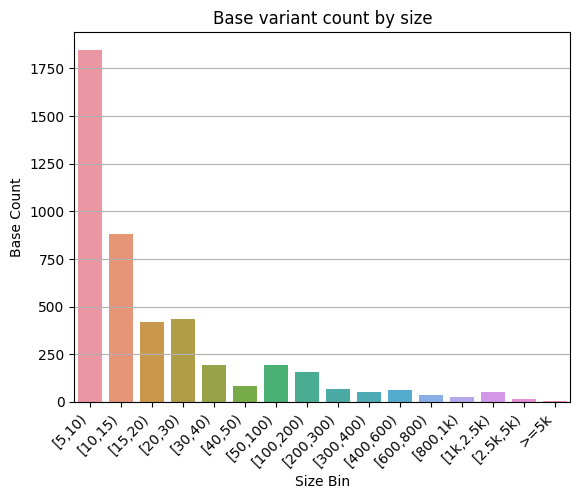

In [99]:
x = data[(data["comp program"] == "Truvari") 
         & (data["caller"] == "HipSTR")
         & (data['szbin'].isin(truvari.SZBINS[2:]))
        ].copy()
x["Base Count"] = x["fn"] + x["tpbase"]
p = sb.barplot(data=x, x="szbin", y="Base Count", order=truvari.SZBINS[2:])
p.set(title="Base variant count by size", xlabel="Size Bin")
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')

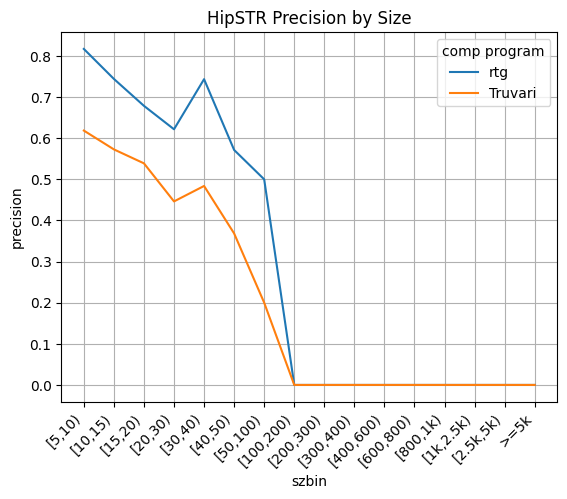

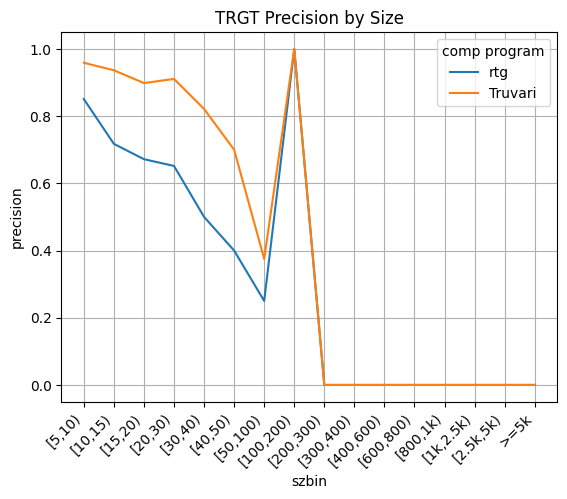

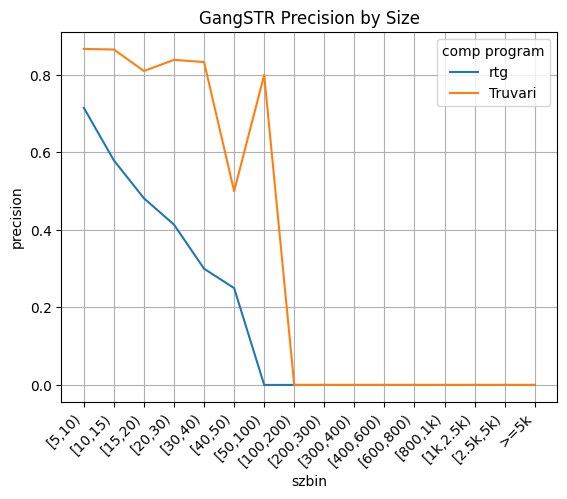

In [68]:
for i in data['caller'].unique():
    keep = data['szbin'].isin(truvari.SZBINS[2:]) & (data['caller'] == i)
    p = sb.lineplot(data=data[keep], x="szbin", y="precision", 
                    hue='comp program', 
                    hue_order=['rtg', 'Truvari'])
    p.set(title=i + " Precision by Size")
    plt.xticks(rotation=45, ha='right')
    plt.grid()
    plt.show()

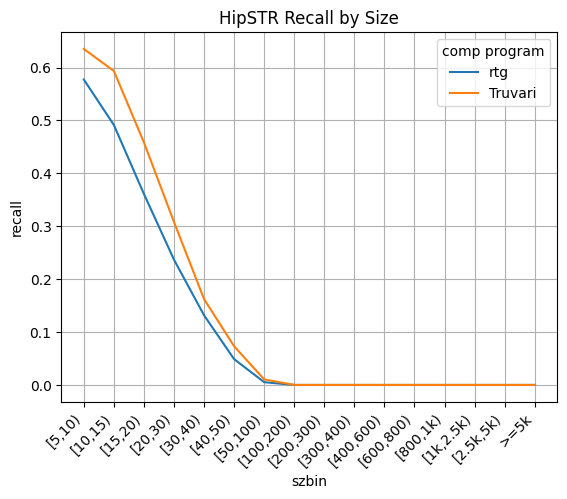

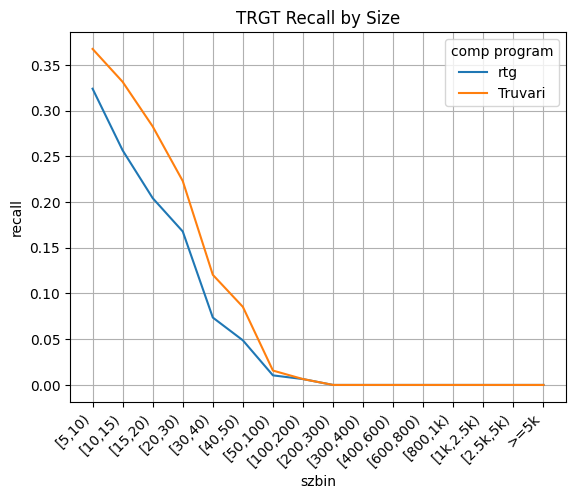

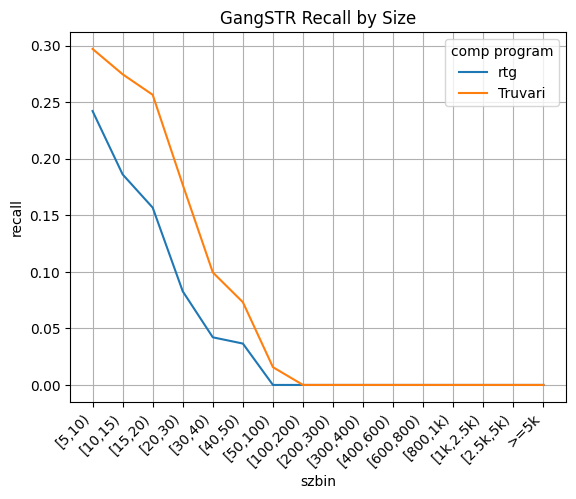

In [69]:
for i in data['caller'].unique():
    keep = data['szbin'].isin(truvari.SZBINS[2:]) & (data['caller'] == i)
    p = sb.lineplot(data=data[keep], x="szbin", y="recall", 
                    hue='comp program', 
                    hue_order=['rtg', 'Truvari'])
    p.set(title=i + " Recall by Size")
    plt.xticks(rotation=45, ha='right')
    plt.grid()
    plt.show()

In [74]:
bench = joblib.load("../tables/adotto_trgt_chr20_bench.jl")

In [75]:
keep = bench['state'].isin(['tp', 'fp'])

[Text(0.5, 1.0, 'TRGT Sequence Similarity by State'),
 None,
 Text(0, 0.5, 'Count (log)')]

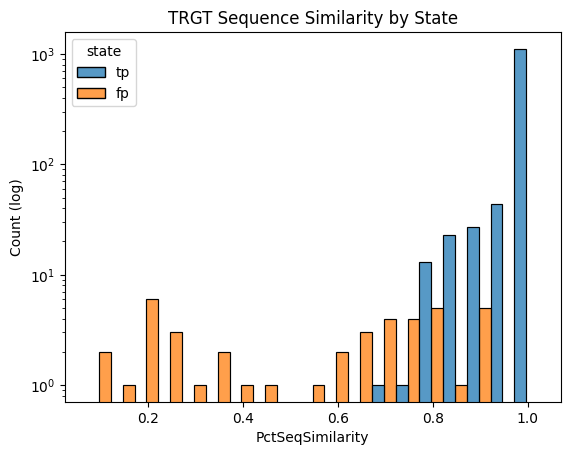

In [82]:
p = sb.histplot(data=bench[keep].reset_index(), 
                x="PctSeqSimilarity", 
                binwidth=0.05, 
                hue='state', 
                multiple='dodge', hue_order=['tp', 'fp'])
p.set(title="TRGT Sequence Similarity by State", yscale='log', ylabel="Count (log)")

[Text(0.5, 1.0, 'TRGT Sequence Similarity by State'), Text(0, 0.5, 'Count')]

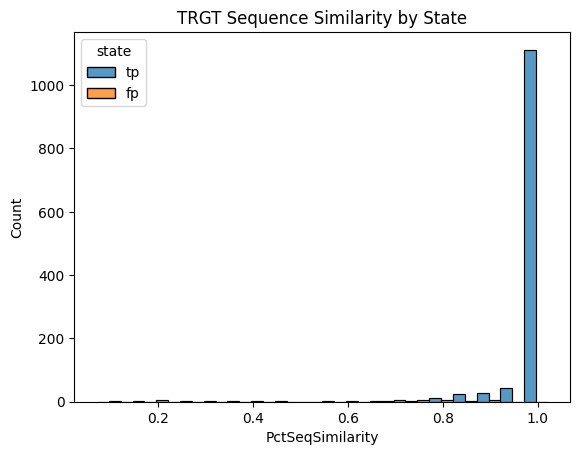

In [84]:
p = sb.histplot(data=bench[keep].reset_index(), 
                x="PctSeqSimilarity", 
                binwidth=0.05, 
                hue='state', 
                multiple='dodge', hue_order=['tp', 'fp'])
p.set(title="TRGT Sequence Similarity by State", ylabel="Count")

[Text(0.5, 1.0, 'TRGT Size Similarity by State'),
 None,
 Text(0, 0.5, 'Count (log)')]

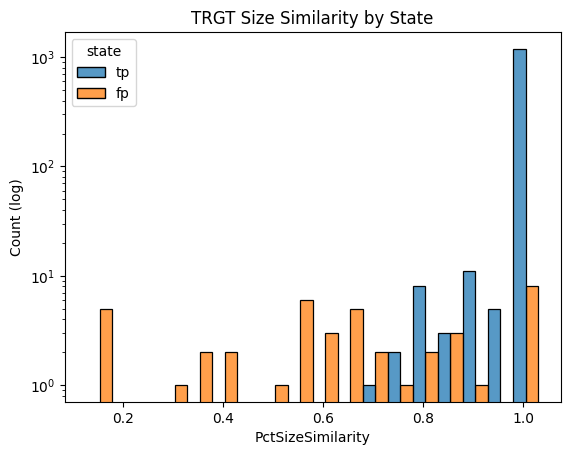

In [88]:
p = sb.histplot(data=bench[keep].reset_index(), 
                x="PctSizeSimilarity", 
                binwidth=0.05, 
                hue='state', 
                multiple='dodge', hue_order=['tp', 'fp'])
p.set(title="TRGT Size Similarity by State", yscale='log', ylabel="Count (log)")

[Text(0.5, 1.0, 'TRGT RecOverlap by State'), None, Text(0, 0.5, 'Count (log)')]

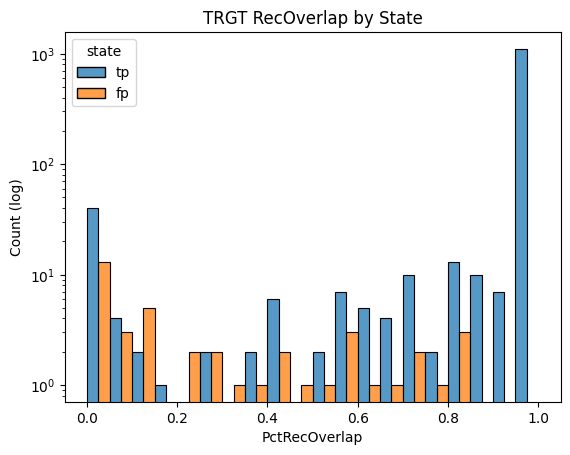

In [87]:
p = sb.histplot(data=bench[keep].reset_index(), 
                x="PctRecOverlap", 
                binwidth=0.05, 
                hue='state', 
                multiple='dodge', hue_order=['tp', 'fp'])
p.set(title="TRGT RecOverlap by State", yscale='log', ylabel="Count (log)")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, '[5,10)'),
  Text(1, 0, '[10,15)'),
  Text(2, 0, '[15,20)'),
  Text(3, 0, '[20,30)'),
  Text(4, 0, '[30,40)'),
  Text(5, 0, '[40,50)'),
  Text(6, 0, '[50,100)'),
  Text(7, 0, '[100,200)'),
  Text(8, 0, '[200,300)'),
  Text(9, 0, '[300,400)'),
  Text(10, 0, '[400,600)'),
  Text(11, 0, '[600,800)'),
  Text(12, 0, '[800,1k)'),
  Text(13, 0, '[1k,2.5k)'),
  Text(14, 0, '[2.5k,5k)'),
  Text(15, 0, '>=5k')])

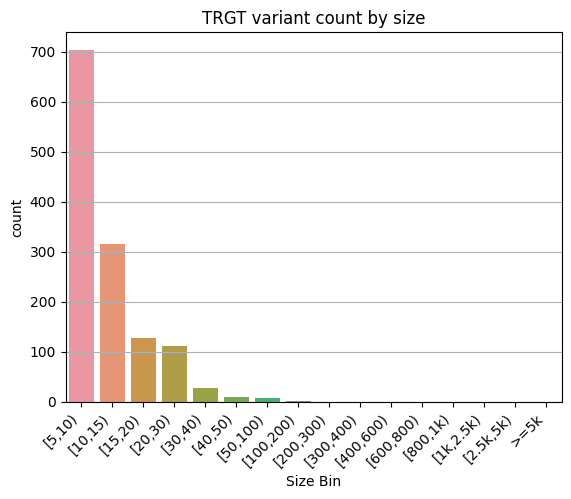

In [102]:
p = sb.countplot(data=bench[keep], x="szbin", order=truvari.SZBINS[2:])
p.set(title="TRGT variant count by size", xlabel="Size Bin")
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')

In [32]:
import truvari
data[data['szbin'].isin(truvari.SZBINS[9:])]

state,szbin,fn,fp,tp,tpbase,precision,recall,f1,comp program,caller,result
9,"[100,200)",156,0,0,0,NaN,0.00000,NaN,rtg,hipstr,rtg:hipstr
10,"[200,300)",67,0,0,0,NaN,0.00000,NaN,rtg,hipstr,rtg:hipstr
11,"[300,400)",54,0,0,0,NaN,0.00000,NaN,rtg,hipstr,rtg:hipstr
12,"[400,600)",64,0,0,0,NaN,0.00000,NaN,rtg,hipstr,rtg:hipstr
13,"[600,800)",38,0,0,0,NaN,0.00000,NaN,rtg,hipstr,rtg:hipstr
14,"[800,1k)",25,0,0,0,NaN,0.00000,NaN,rtg,hipstr,rtg:hipstr
15,"[1k,2.5k)",0,0,0,0,NaN,NaN,NaN,rtg,hipstr,rtg:hipstr
16,"[2.5k,5k)",0,0,0,0,NaN,NaN,NaN,rtg,hipstr,rtg:hipstr
17,>=5k,0,0,0,0,NaN,NaN,NaN,rtg,hipstr,rtg:hipstr
27,"[100,200)",156,0,0,0,NaN,0.00000,NaN,truvari,hipstr,truvari:hipstr


In [12]:
view = data.groupby(['szbin', 'state']).size().unstack()
view['precision'] = view['tp'] / (view['tp'] + view['fp'])
view['recall'] = view['tpbase'] / (view['tpbase'] + view['fn'])
view['f1'] = 2 * ((view['recall'] * view['precision']) / (view['recall'] + view['precision']))
view.reset_index(inplace=True)
view

state,szbin,fn,fp,tp,tpbase,precision,recall,f1
0,SNP,31268,357,832,2520,0.699748,0.074583,0.134798
1,"[1,5)",3526,965,8119,8096,0.893769,0.696610,0.782969
2,"[5,10)",780,248,1108,1066,0.817109,0.577465,0.676697
3,"[10,15)",448,155,451,433,0.744224,0.491487,0.592010
4,"[15,20)",269,80,169,152,0.678715,0.361045,0.471352
5,"[20,30)",332,73,120,103,0.621762,0.236782,0.342957
6,"[30,40)",165,10,29,25,0.743590,0.131579,0.223593
7,"[40,50)",78,6,8,4,0.571429,0.048780,0.089888
8,"[50,100)",190,2,2,1,0.500000,0.005236,0.010363
9,"[100,200)",156,0,0,0,NaN,0.000000,NaN


In [48]:
data

state,szbin,fn,fp,tp,tpbase,precision,recall,f1,comp program,caller,result
0,SNP,31268,357,832,2520,0.699748,0.074583,0.134798,rtg,hipstr,rtg:hipstr
1,"[1,5)",3526,965,8119,8096,0.893769,0.696610,0.782969,rtg,hipstr,rtg:hipstr
2,"[5,10)",780,248,1108,1066,0.817109,0.577465,0.676697,rtg,hipstr,rtg:hipstr
3,"[10,15)",448,155,451,433,0.744224,0.491487,0.592010,rtg,hipstr,rtg:hipstr
4,"[15,20)",269,80,169,152,0.678715,0.361045,0.471352,rtg,hipstr,rtg:hipstr
...,...,...,...,...,...,...,...,...,...,...,...
103,"[600,800)",38,0,0,0,0.000000,0.000000,0.000000,rtg,gangstr,rtg:gangstr
104,"[800,1k)",25,0,0,0,0.000000,0.000000,0.000000,rtg,gangstr,rtg:gangstr
105,"[1k,2.5k)",0,0,0,0,0.000000,0.000000,0.000000,rtg,gangstr,rtg:gangstr
106,"[2.5k,5k)",0,0,0,0,0.000000,0.000000,0.000000,rtg,gangstr,rtg:gangstr


state,szbin,fn,fp,tp,tpbase,precision,recall,f1,comp program,caller,result
0,SNP,31268,357,832,2520,0.699748,0.074583,0.134798,rtg,hipstr,rtg:hipstr
1,"[1,5)",3526,965,8119,8096,0.893769,0.696610,0.782969,rtg,hipstr,rtg:hipstr
2,"[5,10)",780,248,1108,1066,0.817109,0.577465,0.676697,rtg,hipstr,rtg:hipstr
3,"[10,15)",448,155,451,433,0.744224,0.491487,0.592010,rtg,hipstr,rtg:hipstr
4,"[15,20)",269,80,169,152,0.678715,0.361045,0.471352,rtg,hipstr,rtg:hipstr
...,...,...,...,...,...,...,...,...,...,...,...
103,"[600,800)",38,0,0,0,0.000000,0.000000,0.000000,rtg,gangstr,rtg:gangstr
104,"[800,1k)",25,0,0,0,0.000000,0.000000,0.000000,rtg,gangstr,rtg:gangstr
105,"[1k,2.5k)",0,0,0,0,0.000000,0.000000,0.000000,rtg,gangstr,rtg:gangstr
106,"[2.5k,5k)",0,0,0,0,0.000000,0.000000,0.000000,rtg,gangstr,rtg:gangstr


In [103]:
diff = joblib.load("../tables/truvari_match_but_not_rtg.jl")

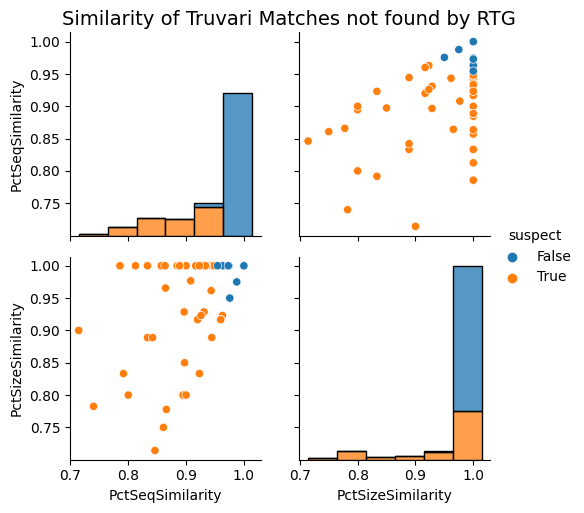

In [125]:
metrics = ["PctSeqSimilarity", "PctSizeSimilarity"]
diff['suspect'] = (diff['PctSeqSimilarity'] < 0.95) | (diff['PctSizeSimilarity'] < 0.95)
# Make plot
g = sb.PairGrid(data=diff.reset_index(), vars=metrics, hue='suspect')
g.map_diag(sb.histplot, binwidth=0.05, multiple='stack')
g.map_offdiag(sb.scatterplot)
g.add_legend()
plt.suptitle('Similarity of Truvari Matches not found by RTG',  y=1.01, 
             size = 14);
plt.show()

[Text(0.5, 1.0, 'TRGT Sequence Similarity by State'),
 Text(0, 0.5, 'Count (log)'),
 (-0.5, 1.05)]

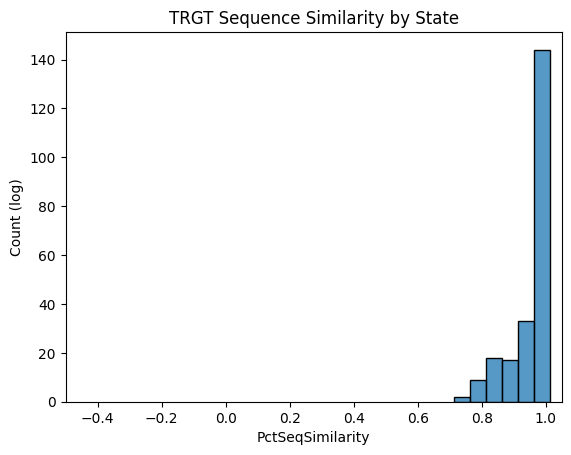

In [115]:
p = sb.histplot(data=diff.reset_index(), 
                x="PctSeqSimilarity", 
                binwidth=0.05, 
                #hue='state', 
                multiple='dodge')#, hue_order=['tp', 'fp'])
p.set(title="TRGT Sequence Similarity by State",ylabel="Count (log)", xlim=(-0.5,1.05))

In [126]:
diff['suspect'].value_counts()

False    148
True      75
Name: suspect, dtype: int64

[Text(0.5, 1.0, 'TRGT RecOverlap by State'), None, Text(0, 0.5, 'Count (log)')]

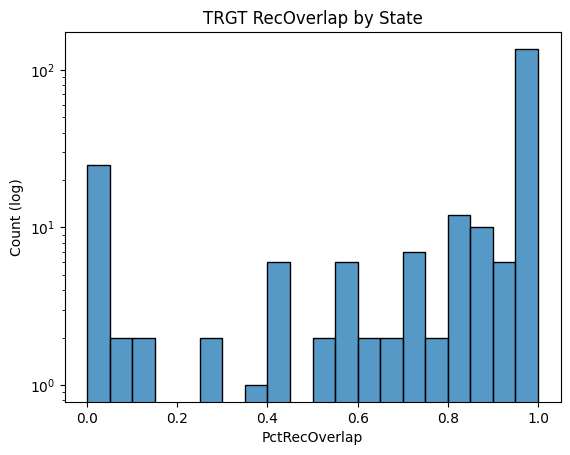

In [110]:
p = sb.histplot(data=diff.reset_index(), 
                x="PctRecOverlap", 
                binwidth=0.05, 
                #hue='state', 
                multiple='dodge')#, hue_order=['tp', 'fp'])
p.set(title="TRGT RecOverlap by State", yscale='log', ylabel="Count (log)")

In [107]:
diff['PctRecOverlap']

key
chr20:10002512-10002521.A                                      1.0000
chr20:10028301-10028314.A                                      0.9231
chr20:10034898-10034923.G                                      1.0000
chr20:10116787-10116824.C                                      0.9730
chr20:10540095-10540096.TTCCTTTCCTTCCTTCCTTCC                  1.0000
                                                                ...  
chr20:9061678-9061679.CTCTTTCTTTCTTTCTTTCTTTCTTTCTTTCTTTCTT    0.4286
chr20:9127637-9127654.T                                        1.0000
chr20:9222035-9222056.G                                        1.0000
chr20:9307493-9307506.T                                        0.8462
chr20:9962742-9962753.A                                        1.0000
Name: PctRecOverlap, Length: 223, dtype: float32

In [175]:
trgt = pd.read_csv("../tables/hipstr.rebench.counts.txt", sep='\t')
print(trgt["reevaled"].value_counts())

for i in ['fp_count', 'fn_count', 'tp_base_count', "tp_call_count"]:
    print(i)
    trgt['same'] = trgt['in_' + i] == trgt['out_' + i]
    print(trgt.groupby(['reevaled', 'same']).size().unstack())

False    31966
True       122
Name: reevaled, dtype: int64
fp_count
same      False     True
reevaled                
False       NaN  31966.0
True      117.0      5.0
fn_count
same      False     True
reevaled                
False       NaN  31966.0
True       84.0     38.0
tp_base_count
same      False     True
reevaled                
False       NaN  31966.0
True       83.0     39.0
tp_call_count
same      False     True
reevaled                
False       NaN  31966.0
True       83.0     39.0


In [180]:
trgt = pd.read_csv("../tables/trgt.rebench.counts.txt", sep='\t')


trgt['same'] = (trgt['in_tp_base_count'] == trgt['out_tp_base_count']) & \
               (trgt['in_tp_call_count'] == trgt['out_tp_call_count']) & \
               (trgt['in_fn_count'] == trgt['out_fn_count']) & \
               (trgt['in_fp_count'] == trgt['out_fp_count'])
print(trgt.groupby(['reevaled', 'same']).size().unstack())

same      False     True
reevaled                
False       NaN  32062.0
True       13.0     13.0


In [166]:
data = joblib.load("

same,False,True
reevaled,,
False,NaN,32032.0
True,15.0,41.0


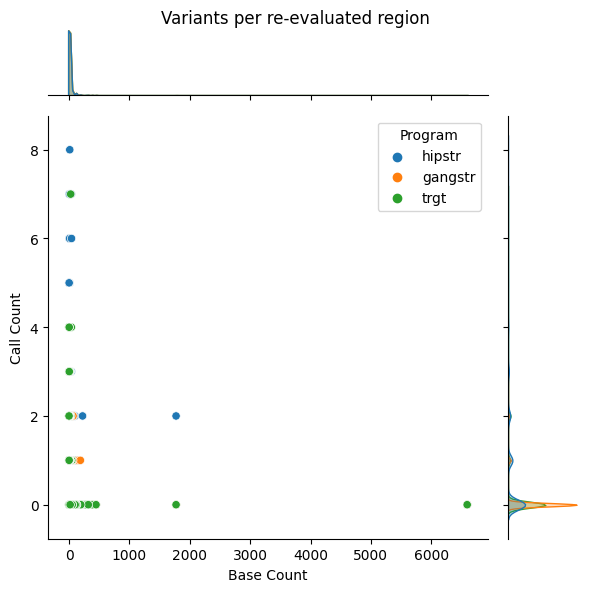

In [208]:
parts = []
for i in ['hipstr', 'gangstr', 'trgt']:
    trgt = pd.read_csv(f"../tables/{i}.rebench.counts.txt", sep='\t')
    view = trgt[~trgt['reevaled']][["base_count", "call_count"]].copy()
    view['program'] = i
    view.columns = ["Base Count", "Call Count", "Program"]
    parts.append(view)
view =pd.concat(parts)

#sb.scatterplot(data=view, x="base_count", y="call_count", hue="program")
p = sb.jointplot(x="Base Count", 
                 y="Call Count",
                 edgecolor="white",
                 hue="Program",
                 data=view);
p.fig.suptitle("Variants per re-evaluated region")
#p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
#p.set(title=", xlabel="Base Count", ylabel="Comp Count")

In [210]:
view[(view["Base Count"] != 0) & (view["Call Count"] != 0)][["Base Count", "Call Count"]].describe()

,Base Count,Call Count
count,13716.000000,13716.000000
mean,2.051400,1.526830
std,15.739904,0.767985
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,1773.000000,8.000000


In [215]:
data = joblib.load("../tables/adotto_trgt_chr20_bench.jl")

In [221]:
view = data[data['state'] == 'tpbase']
keep = (view['PctSeqSimilarity'] >= 0.95) & (view["PctSizeSimilarity"] >= 0.95)

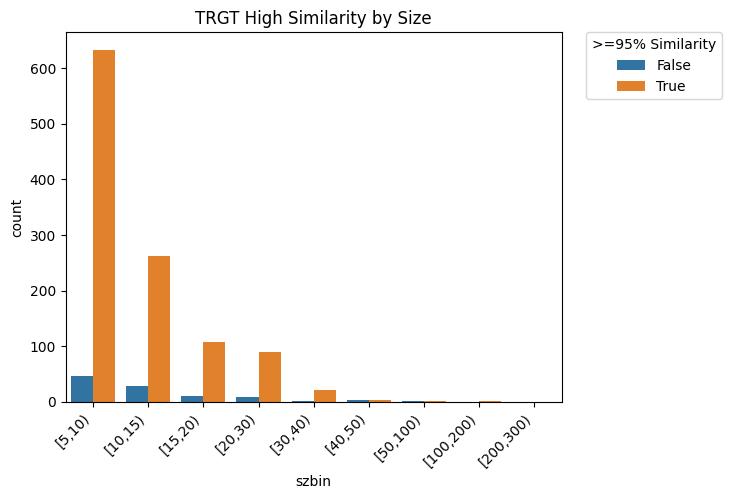

In [236]:
view = view.copy()
view['High Similarity'] = keep
p = sb.countplot(data=view, x="szbin", hue="high sim", order=truvari.SZBINS[2:11])
p.set(title="TRGT High Similarity by Size")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=">=95% Similarity")

hide = plt.xticks(rotation=45, ha='right')

In [223]:
view[~keep]['svlen'].describe()

count    100.000000
mean      13.160000
std        9.697152
min        5.000000
25%        8.000000
50%       11.000000
75%       14.250000
max       65.000000
Name: svlen, dtype: float64

In [237]:
s = """    726 chr1
    642 chr2
    563 chr7
    560 chr6
    488 chr4
    455 chr11
    450 chr5
    441 chr8
    439 chr3
    439 chr10
    411 chr12
    382 chr9
    368 chr17
    344 chr13
    339 chr19
    331 chr16
    330 chrX
    317 chr20
    249 chr18
    233 chr22
    211 chr14
    195 chr15
    174 chr21
     22 chrY"""
p = []
for i in s.split('\n'):
    p.append(int(s.strip().split(' ')[0]))
p = pd.Series(p)

In [239]:
p.sum()

17424